In [ ]:
# default_exp data

In [ ]:
#export
from snkrfinder.imports import *
from snkrfinder.core import *

import scipy.io as sio
from sklearn.model_selection import train_test_split
### might be fastai wrappers to do this elegantly... (untar_data?)
import os
import shutil


In [ ]:

#hide
from nbdev.showdoc import *

# snkrfinder.data

### version 1.0 Dec 2020 (refactor using pytorch/nbdev/fastai framework)

## OVERVIEW

This is a project initiated while an Insight Data Science fellow.  It grew out of thinking about how to make data-driven tools that could impact the fashion industry which I had been working working in.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some sneaker designs based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

NOTE:  symbolic link in the nbs directory to enable the module loads in these notebooks.  i.e. `ln -s ../snkrfinder/ snkrfinder`


### A: load databases / imagefile names to dataframes

### B: organize imagefiles into folders according to meta-data (category/source)

### C: splitters ... e.g. train, valid, test

### D: move files

### E: load and merge scraped data 



This is a cool reference for a fastai VAE
https://medium.com/@dhuynh95/an-introduction-to-unsupervised-learning-with-fastai-a6dbd78eca2b


First we need to get a database of sneaker images.   The sneaker images are only 136 pixels wide, and organized by 'Category', 'SubCategory', and 'Brand'.   Additional semantic information is also available from Mechanical Turk labeling, and is available packed into matlab files.  

In [ ]:
#hide

print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/Projects/Project2.0/snkr-finder


## Part 0: DATA

### Part 1: import the UT-Zappos50k database

Using fastai `untar_data`.

In [ ]:
#export
def get_zappos_db():
    "import the UT zappos 50k database from vision.cs.utexas.edu"
    # the images are wider than tall with the product already taking up aproximately the whole vertical dimension
    url_images = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip"
    url_meta = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-data.zip"

    DATA_path = D_ROOT
    meta_path = untar_data(url_meta, dest=DATA_path)
    im_path = untar_data(url_images,dest=DATA_path)
    
    return meta_path, im_path

### data set cleaning

The dataset is very diverse and not constructed in order to think about how popular footwear is aesthetically related.  I'm simplifying the database to include 4 categories which seem to split aesthetics for general footwear:

1) BOOTS - weatherized and/or protected footwear for work or outdoor activity
2) SANDALS - charachterized by a sole and straps
3) SHOES - generic non "boot" footwear.  includes heels and formalwear
4) SNEAKERS - atheletic / comfort inspired 

In [ ]:
#export

def read_zappos_meta(path_meta):
    "read the metadat from UT zappos 50k db"

    def _path_from_mat(fname):
        """ reads zappos imagepath from matlab file"""
        data = sio.loadmat(fname)['imagepath']
        return [i[0][0] for i in data]

    image_path = _path_from_mat(path_meta/'image-path.mat')
    df = pd.read_csv(path_meta/'meta-data.csv')

    df["path"]=image_path
    
    # ad sub-categories (one-hot)
    categories=pd.read_csv(path_meta/'meta-data-bin.csv')
    df = pd.merge(df, categories,  how='left', on='CID')# left_on=['CID'], right_on = ['CID'])


    # fix the path by remove trailing periods in folder names
    df.loc[df.path.str.contains("./",regex=False),"path"] = [i.replace("./","/") for i in df.loc[df.path.str.contains("./",regex=False),"path"]]
    df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"] = [i.replace("Levi\'s ","Levis ") for i in df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"]]
    # create brands and category stubs...
    df['path_and_file'] = df.path.apply(lambda path: (os.path.normpath(path)).split(os.sep) ) 
    df_to_add = pd.DataFrame(df['path_and_file'].tolist(), columns=['Category1','Category2','Brand','Filename'])

    df = df.merge(df_to_add, left_index=True, right_index=True)
    #df = pd.merge(df, df_to_add, left_index=True, right_index=True)
    return df


In [ ]:
meta_path, im_path = get_zappos_db()

assert (meta_path==ZAPPOS_META_DIR)
assert(im_path==D_ROOT/DBS["zappos"])


In [ ]:
df = read_zappos_meta(meta_path)

assert (df['Category'] == df['Category1']).all()
assert (df['SubCategory'] == df['Category2']).all()

### simplify:

Categories:
    1. SHOES, 
    2. BOOTS, 
    3. "SNEAKERS", and 
    4. "SLIPPERS"

[[ TODO:  change the bullets to a short paragraph describing the simplificaiton ]]

Only include "adult" shoes
    - Adult = mens + womens (kids = not adults),+ etc (unisex)

To construct these from the Zappos I needed to pull sneakers from shoes and exclude some sub-categories.  e.g. tall boots which would drive the representation of boots.

    BOOTS:
      BOOTS
        - ankle,  mid-calf
        - exclude: knee high , over the knee , prewalker

    SANDALS:
      SANDALS
        - athletic, flat
        - exclude: heels 
        
    SHOES:
      SHOES
        - Boat shoes, clogs and mules,  flats,  loafers, oxfords, prewalker
        - exclude: heels , crib shoes , firstwalker (exclude)

    SNEAKERS
       SHOES
       - sneakers and athletic shoes

     SLIPPERS (exclude)

In [ ]:
#export

def simplify_zappos_db(df):
    " simplifies the db (df)"
    # add our "sneaker category"
    df.loc[:,'Sneakers'] = (df['Category2'] == 'Sneakers and Athletic Shoes')

    # refine boot
    df.loc[:,'Boots'] = (  (df.Category1 == 'Boots') 
                         & (df.Category2 != 'Knee High')
                         & (df.Category2 != 'Over the Knee')
                         & (df.Category2 != 'Prewalker Boots') )

    # refine shoes
    df.loc[:,'Shoes'] = (  (df.Category1 == 'Shoes') 
                         & (df.Category2 != 'Sneakers and Athletic Shoes')
                         & (df.Category2 != 'Heels')                         
                         & (df.Category2 != 'Crib Shoes')
                         & (df.Category2 != 'Firstwalker')
                         & (df.Category2 != 'Prewalker') )

    # refine shoes
    df.loc[:,'Slippers'] = (  (df.Category1 == 'Slippers')
                         & (df.Category2 != 'Boot') )


    ############
    #remove ([ 'Boys',  'Boys;Girls', 'Girls','Women;Girls', nan

    mens =  df['Gender'] == 'Men'       
    womens =  df['Gender'] == 'Women' 
    etc =  df['Gender'].str.contains('Men;', na=False)

    df.loc[:,'Adult'] = mens | womens | etc

    df.loc[:,'Mens'] = mens 
    df.loc[:,'Womens'] = womens

    df.loc[:,'OGcategory'] = df.Category
    df.loc[:,'Category'] = pd.NA

    df.loc[(df.Shoes==1),'Category'] = 'Shoes'
    df.loc[(df.Boots==1),'Category'] = 'Boots'
    df.loc[(df.Sneakers==1),'Category'] = 'Sneakers'
    df.loc[(df.Slippers==1),'Category'] = 'Slippers'

    
    # make some expository columns 
    keep_columns = ['CID','Category',
                     'path','path_and_file',
                     'Category1', 'Category2','OGcategory'
                     'Brand','Filename',
                     'Sneakers','Boots',
                     'Shoes', 'Slippers','Adult',
                     'Gender']

    df = df.filter(items=keep_columns)
    #keep Adult, Sneakers, Boots, Shoes, Slippers
    keep_rows = (df.Sneakers | df.Boots | df.Shoes| df.Slippers) & (df.Adult)
    #Only keep Adult (men+women) and Sneakers, Boots, Shoes
    df = df[keep_rows.values]
    return df

In [ ]:
#hide
df.Category.unique()


array(['Shoes', 'Boots', 'Sandals', 'Slippers'], dtype=object)

In [ ]:
df = simplify_zappos_db(df)

In [ ]:
#after
df.head()

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender
0,100627-72,Shoes,Shoes/Oxfords/Bostonian/100627.72.jpg,"[Shoes, Oxfords, Bostonian, 100627.72.jpg]",Shoes,Oxfords,100627.72.jpg,False,False,True,False,True,Men
1,100627-255,Shoes,Shoes/Oxfords/Bostonian/100627.255.jpg,"[Shoes, Oxfords, Bostonian, 100627.255.jpg]",Shoes,Oxfords,100627.255.jpg,False,False,True,False,True,Men
2,100657-72,Shoes,Shoes/Oxfords/Bostonian/100657.72.jpg,"[Shoes, Oxfords, Bostonian, 100657.72.jpg]",Shoes,Oxfords,100657.72.jpg,False,False,True,False,True,Men
3,100657-216,Shoes,Shoes/Oxfords/Bostonian/100657.216.jpg,"[Shoes, Oxfords, Bostonian, 100657.216.jpg]",Shoes,Oxfords,100657.216.jpg,False,False,True,False,True,Men
4,101026-3,Boots,Boots/Mid-Calf/Durango/101026.3.jpg,"[Boots, Mid-Calf, Durango, 101026.3.jpg]",Boots,Mid-Calf,101026.3.jpg,False,True,False,False,True,Men


------------

## Prepare the simplified dataframe for further analysis


Also use sklearn `train_test_split` to create category stratified train/test/validate groups.  We'll keep 15 percent of our data to truly test.

In [ ]:
df.shape

(27614, 13)

In [ ]:
#export

def skl_tt_split(df,strat_cat):
    "adds stratified train-validate-test via sklearn"


    X = df.index
    y = strat_cat

    train_ratio = 0.70
    validation_ratio = 0.15

    # keep
    test_ratio = 0.15

    # train is now 75% of the entire data set
    # the _junk suffix means that we drop that variable completely
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,stratify=y, random_state=666)

    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test, random_state=666) 
    # pack into the dataframe
    df.loc[:,'train'] = False
    df.loc[:,'test'] = False
    df.loc[:,'validate'] = False
    df.loc[:,'t_t_v'] = 'train'
    df.loc[x_train,'train'] = True
    df.loc[x_test,'test'] = True
    df.loc[x_val,'validate'] = True
    df.loc[x_test,'t_t_v'] = 'test'
    df.loc[x_val,'t_t_v'] = 'valid'
    return df

    

In [ ]:
#hide
df = skl_tt_split(df,df.Category)
df.head()

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v
0,100627-72,Shoes,Shoes/Oxfords/Bostonian/100627.72.jpg,"[Shoes, Oxfords, Bostonian, 100627.72.jpg]",Shoes,Oxfords,100627.72.jpg,False,False,True,False,True,Men,True,False,False,train
1,100627-255,Shoes,Shoes/Oxfords/Bostonian/100627.255.jpg,"[Shoes, Oxfords, Bostonian, 100627.255.jpg]",Shoes,Oxfords,100627.255.jpg,False,False,True,False,True,Men,False,True,False,test
2,100657-72,Shoes,Shoes/Oxfords/Bostonian/100657.72.jpg,"[Shoes, Oxfords, Bostonian, 100657.72.jpg]",Shoes,Oxfords,100657.72.jpg,False,False,True,False,True,Men,True,False,False,train
3,100657-216,Shoes,Shoes/Oxfords/Bostonian/100657.216.jpg,"[Shoes, Oxfords, Bostonian, 100657.216.jpg]",Shoes,Oxfords,100657.216.jpg,False,False,True,False,True,Men,True,False,False,train
4,101026-3,Boots,Boots/Mid-Calf/Durango/101026.3.jpg,"[Boots, Mid-Calf, Durango, 101026.3.jpg]",Boots,Mid-Calf,101026.3.jpg,False,True,False,False,True,Men,True,False,False,train


------------

## pickle the dataframes

In [ ]:

# save it
filename = "zappos-50k-simplified"
#df.to_csv(f"data/{filename}.csv")
df.to_pickle(f"data/{filename}.pkl")


In [ ]:
#hide
df2 = df.sort_values('path', ascending=True)
df2 = df2.reset_index(drop=True)
#df4_[["CID","path","classes"]].head(5)

filename = "zappos-50k-simplified_sort"
#df.to_csv(f"data/{filename}.csv")
df2.to_pickle(f"data/{filename}.pkl")
df2.to_json(f"data/{filename}.json")

## unpickle the dataframe

In [ ]:


filename = "zappos-50k-simplified_sort"
df = pd.read_pickle(f"data/{filename}.pkl")



------------

## Do Train Test Splits


In [ ]:
#hide
# UPDATE - JAH, put all data into DATABASE 
im_path = D_ROOT/DBS['zappos'] #'ut-zap50k-images'

lpath = './data'



In [ ]:
#export

def add_subdir(root,dname):
    l_path = os.path.join(root,dname)
    if not os.path.exists(l_path):
        os.makedirs(l_path)
    return l_path

def creat_full_local_categorydirs(df,lpath,dpath=None):
    # create full set
    print('_'*30)
    print('Creating full local category set....')
    print('_'*30)
    ldata_path = add_subdir(lpath,'raw')
    data_path = dpath if dpath is not None else D_ROOT/DBS['zappos']

    train_path = add_subdir(lpath,'train')
    val_path = add_subdir(lpath,'validate')
    test_path = add_subdir(lpath,'test')

    n_copied = 0
    train_moved = 0
    val_moved = 0
    test_moved = 0
    for idx in df.index:        
        save_path = add_subdir(ldata_path,df.loc[idx,'Category'])
        img =  os.path.join(data_path,df.loc[idx,'path'])
        shutil.copy2(img,save_path)
        n_copied += 1
        
        save_path = add_subdir(ldata_path,df.loc[idx,'Category'])
        img =  os.path.join(data_path,df.loc[idx,'path'])
        shutil.copy2(img,save_path)
        train_moved += 1
    return n_moved



In [ ]:
#export

def create_test_train_directories(df,lpath,dpath=None):
    "copy the database and split images into test/train sub-directories"
    def _sort_ttv(img,ldata_path,ttv,nttv):
        if ttv=='train':
            nttv['train'] += 1
            save_path = add_subdir(os.path.join(lpath,'train'),df.loc[idx,'Category'])
            shutil.copy2(img,save_path)
        elif ttv=='test':
            nttv['test'] += 1
            save_path = add_subdir(os.path.join(lpath,'test'),df.loc[idx,'Category'])
            shutil.copy2(img,save_path)
        elif ttv=='valid':
            nttv['valid'] += 1
            save_path = add_subdir(os.path.join(lpath,'validate'),df.loc[idx,'Category'])
            shutil.copy2(img,save_path)
        else:
            print(f"error:{img} not t t v")  #TODO: make this propagate an error instead of 
            
    data_path = dpath if dpath is not None else D_ROOT/DBS['zappos']

    ldata_path = add_subdir(lpath,'raw')

    train_path = add_subdir(lpath,'train')
    val_path = add_subdir(lpath,'valid')
    test_path = add_subdir(lpath,'test')
    
    nttv = {'train':0,'test':0,'valid':0}
    # create test set (copies everything...)
    print('_'*30)
    print('Creating full train/test/validate set (+raw copy)....')
    print('_'*30)

    n_moved = 0
    for idx in df.index:        
        save_path = add_subdir(ldata_path,df.loc[idx,'Category'])
        img =  os.path.join(data_path,df.loc[idx,'path'])
        shutil.copy2(img,save_path)
        n_moved += 1
        
        ttv = df.loc[idx,'t_t_v']
        # now copy it to the destination
        _sort_ttv(img,ldata_path,ttv,nttv)

        #     n_train = nttv['train']
        #     n_valid = nttv['validate']
        #     n_test = nttv['test']

    return n_moved, nttv['train'], nttv['valid'], nttv['test']


In [ ]:
#n_images = creat_full_local_categorydirs(df,lpath)
if False:
    n_images, n_train, n_val, n_test = create_test_train_directories(df,lpath)
    n_images,n_train,n_val,n_test


------------

## ImageDataLoader instead of block API 

TODO: STASH

alternative format... just park here until i can stash it away.

In [ ]:
dls = ImageDataLoaders.from_df(df, path=im_path,fn_col='path',label_col='Category',valid_pct=0.0)

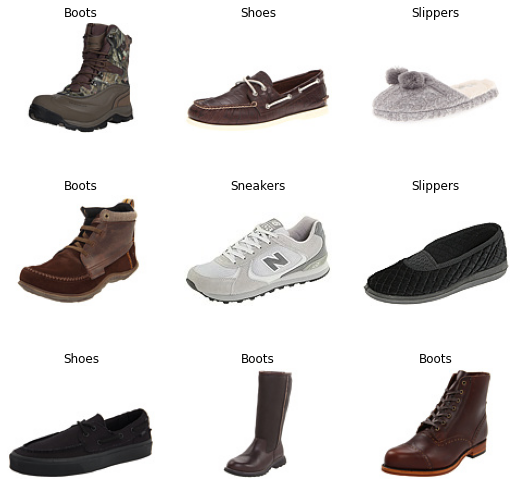

In [ ]:
dls[0].show_batch()

In [ ]:
    
tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

item_tfms = [Resize(160,method='pad', pad_mode='border')]
batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

# put everythign in train, and don't do any augmentation since we are just going 
def get_x(r): return im_path/r['path']
def get_y(r): return r['Category']
#def get_feat(r): return r["Unnamed: 0"]
def get_feat(r): return r['path']
#def get_feat(r): return r['CID']


# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)  # border pads white...

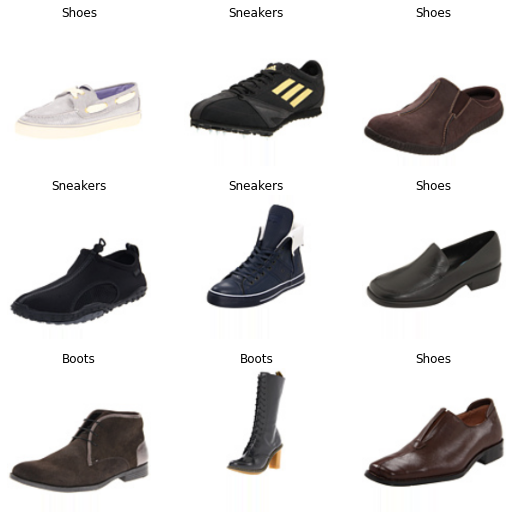

In [ ]:
dls = dblock.dataloaders(df,bs=256,drop_last=False)


dls.show_batch()

------------

## Create a simple database of "sneakers"

- images (need to access) path to fit beta-VAE 
- descriptions for fitting text autoencoder
- skip "meta" data (will come back to this later for further analysis.

In [ ]:
filename = ZAPPOS_DF_SIMPLIFIED #"zappos-50k-simplified_sort"
df_zappos = pd.read_pickle(f"data/{filename}.pkl")

In [ ]:
SCRAPED_META_DIR/SCRAPED_DF


Path('/home/ergonyc/Projects/DATABASE/SnkrScrpr/data/full_data')

In [ ]:
df_scraped = pd.read_pickle(f"{SCRAPED_META_DIR/SCRAPED_DF}.pkl")

# load into pandas
attributes = df_scraped.attributes.values
description = df_scraped.description.values
df_scraped[['url','hero_fullpath']].head(2)

,url,hero_fullpath
0,https://www.goat.com/sneakers/air-jordan-11-retro-bred-2012-378037-010,/Users/ergonyc/Projects/DATABASE/SnkrScrpr/data/goat/img/99543f4630.jpg
1,https://www.goat.com/sneakers/yeezy-boost-700-carbon-blue-yzy-700-what-the,/Users/ergonyc/Projects/DATABASE/SnkrScrpr/data/goat/img/3fbd48e729.jpg


I need to put the scraped databases from SNS (sneakersnstuff.com) and GOAT (goat.com) into a dataframe with columns suitable merge with the UTZappos database I originally started with.   
I'll spend some time infering the `Category`, `Brand`, `Gender` (and `model`?) so I can pay attention to class balance .  From the transfer learning work, the `Slippers` category is pretty poor, but I should be able to use that net to label the scraped data... and validate based on the `attributes` and `see_also` fields.

First things first:  fix the "hero_fullpath" so its agnostic of OS (Mac or Linux).


In [ ]:
# this cooresponds to the relative path in DBS_REL['goat'] and DBS_REL['sns']
df_scraped.loc[:,"path"]=df_scraped.hero_fullpath.str.split('/').apply(lambda x: 'scraped/'+x[-3]+'/'+x[-1])
df_scraped["path"].head(),df_scraped["path"].tail()

(0    scraped/goat/99543f4630.jpg
 1    scraped/goat/3fbd48e729.jpg
 2    scraped/goat/6721456f62.jpg
 3    scraped/goat/27fbbaad00.jpg
 4    scraped/goat/df16a19226.jpg
 Name: path, dtype: object,
 1333    scraped/sns/eb4f3eada8.jpg
 1334    scraped/sns/5dace85f70.jpg
 1335    scraped/sns/2a18731113.jpg
 1336    scraped/sns/9cb275f3aa.jpg
 1337    scraped/sns/6d6c0b7b97.jpg
 Name: path, dtype: object)

In [ ]:
#export
def extract_cat(lst):
    for l in lst:
        if l.startswith("CATEGORY"):
            return l.split("\n")[-1]
    return "na" #np.nan

def extract_brand_goat(lst):
    for l in lst:
        if l.startswith("BRAND"):
            return l.split("\n")[-1]
    return "na"

def extract_brand_sns(lst):
    return lst[1]

def extract_db_nm(pathn):
    return pathn.split('/')[0]


In [ ]:
df_scraped.loc[:,"brand"]=df_scraped.attributes.apply(extract_brand_sns)
df_scraped.loc[:,"cat"]=df_scraped.attributes.apply(extract_cat)


In [ ]:

df_scraped["attributes"].values[-5]
df_scraped["path"].values[0].split("/")[1]

'goat'

In [ ]:
df_scraped.loc[:,"db_name"]=df_scraped["path"].apply(extract_db_nm)

df_scraped.loc[df_scraped['db_name']=='goat',"brand"]=df_scraped.loc[df_scraped['db_name']=='goat',"attributes"].apply(extract_brand_goat)

In [ ]:
df_scraped_og = df_scraped

Now we just need to wrap the above proceedure into a little function for exporting...

In [ ]:
# export
def get_scraped_db():
    "collect meta data fromscraped databases"
    
    def _extract_cat(lst):
        for l in lst:
            if l.startswith("CATEGORY"):
                return l.split("\n")[-1]
        return "na" #np.nan

    def _extract_brand_goat(lst):
        for l in lst:
            if l.startswith("BRAND"):
                return l.split("\n")[-1]
        return "na"

    def _extract_brand_sns(lst):
        return lst[1]

    def _extract_db_nm(pathn):
        return pathn.split('/')[0]
    
    df_scraped = pd.read_pickle(f"{SCRAPED_META_DIR/SCRAPED_DF}.pkl")
    df_scraped.loc[:,"path"]=df_scraped.hero_fullpath.str.split('/').apply(lambda x: 'scraped/'+x[-3]+'/'+x[-1])
    df_scraped.loc[:,"brand"]=df_scraped.attributes.apply(_extract_brand_sns)
    df_scraped.loc[:,"cat"]=df_scraped.attributes.apply(_extract_cat)
    df_scraped.loc[:,"db_name"]=df_scraped["path"].apply(_extract_db_nm)
    df_scraped.loc[df_scraped['db_name']=='goat',"brand"]=df_scraped.loc[df_scraped['db_name']=='goat',"attributes"].apply(_extract_brand_goat)
    return df_scraped


In [ ]:
# export
def merge_dbs(df_zappos,df_scraped):
    "could be any dfs with 'path','train','test','validate','t_t_v'"
    # TODO:  add "is_valid" wiich is test and (so validate are part of test)?)
    return pd.merge(df_zappos,df_scraped,how='outer',on=['path','train','test','validate','t_t_v'])

In [ ]:
df = get_scraped_db()

In [ ]:
# stratify across db_name
# skl_tt_split defined in data.zappos
df_scraped = skl_tt_split(df,df.db_name)

In [ ]:
df_test = merge_dbs(df_zappos,df_scraped)

df_scraped.columns,df_zappos.columns,df_test.columns

df_scraped.shape,df_zappos.shape,df_test.shape

((2337, 17), (27614, 17), (29951, 29))

In [ ]:
# save the combined db for easy access later.
df_test.to_pickle(os.path.join("data", f"{COMBINED_DF}.pkl"))


------------

In [ ]:
#hide

from nbdev.export import notebook2script
notebook2script()



Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02a_model.core.ipynb.
Converted 02b_model.transfer.ipynb.
Converted 02c_model.cvae.ipynb.
Converted 04_widgets.ipynb.
Converted index.ipynb.


------------